# <center>Gold Prediction ARIMA-GARCH semi model</center>

<center>Franck Bui Nguyen</center>
<center>email : franck5nguyen@gmail.com</center>

The purpose of this paper is to: 

1) understand the different variable that can affect the gold spot price and the interraction with all other asset classes from cross commodities to equities and forex

2) Forecast gold spot price on a short term (about 1 month in the future) using several paper research 
* https://www.researchgate.net/publication/324273329_Trading_gold_future_with_ARIMA-GARCH_model

Note : Main languages used are Python, C++ and some R

# Summary
* Correlation studies
* Forecasting using ARIMA(P,D,Q)
* Presentation GARCH(P,Q)
* Forecasting using hybrid ARIMA-GARCH model

## ARIMA Model

$X_t - \alpha_{1} X_{t-1}-...- \alpha_p X_{t-p} = \epsilon_{t} + \theta_1 \epsilon_{t-1} + .... + \theta_q \epsilon_{t-q}$ 

## GARCH Model
Problem with variance, we are using GARCH model to modelise the 2nd moment of a time series

$\sigma^2_t = \alpha_0 + \alpha_1 \epsilon^2_1 + ... + \alpha_q \epsilon^2_{t-q} = \alpha_0 + \sum_{i=1}^q \alpha_i \epsilon_{t-i}^2$

In [6]:
import dataMngt as dtmgt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
#get gold data from 2006 till now
all = pd.read_csv(r'C:\Python Project\Commodities\Data\stocks.csv',index_col=False)
EQD = all.loc[all.type == 'EQD']
CTY = all.loc[all.type == 'CTY']
FX = all.loc[all.type == 'FX']

#Format table
allFormat = dtmgt.unstackData(all)
EQDFormat = dtmgt.unstackData(EQD,typeList = ['EQD'])
CTYFormat = dtmgt.unstackData(CTY,typeList = ['CTY'])
FXFormat = dtmgt.unstackData(FX,typeList = ['FX'])

## Correlation 

First lets get an overall look of what the gold spot price looks like from 1st of January 2006 until now

Text(0, 0.5, 'Price in $/oz')

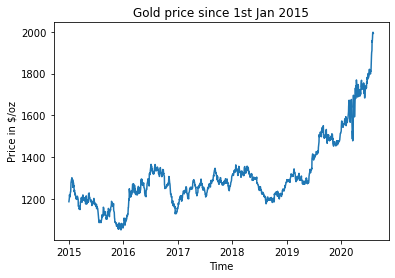

In [26]:
xau = allFormat.XAU #Gold price

sns.lineplot(data=xau)
plt.title("Gold price since 1st Jan 2015")
plt.xlabel('Time')
plt.ylabel('Price in $/oz')

# Coronavirus 
The coronavirus hitted financial market around early April 2020 as we can clearly see the deep. During the following month, gold has seen an un-precedented bullish market.

The first reason is that during time of uncertainty, investissors wish to hedge themselves against various factors, for example the power of a money can severely decrease if a country is heated severely by the crisis or hedging against potential volatil underlying asset.

One way to do so is to invest in safe heavens and for ages, gold has proven to be safe and especially in emerging countries.

[]

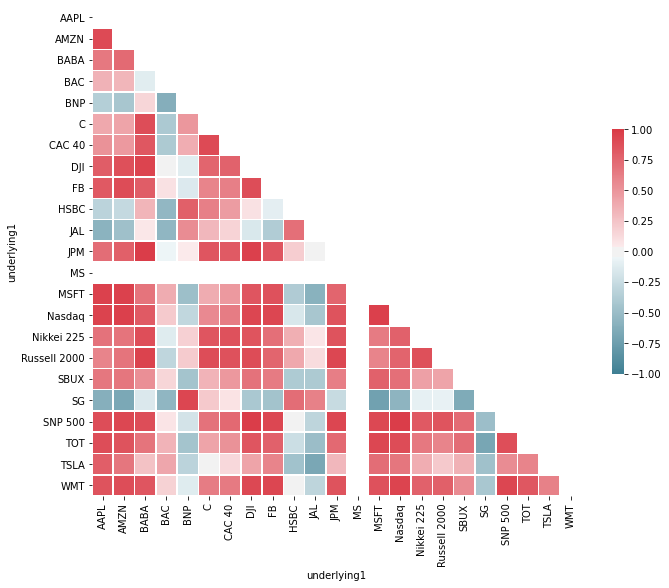

In [3]:
#Calculate correlation between each asset
corrAll, maskALL = dtmgt.corrParam(allFormat)
corrEQD, maskEQD = dtmgt.corrParam(EQDFormat)
corrCTY, maskCTY = dtmgt.corrParam(CTYFormat)
corrFX, maskFX = dtmgt.corrParam(FXFormat)

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
dtmgt.corrPlot(corrEQD,maskEQD)

plt.plot()

30/09/2020